# Laboratorio ERF

>Trabalho Prático n.º 5

## Projecto de um filtro passa-banda

1. Projecte um filtro passa-banda com as seguintes características:
    - Impedância característica $Z_0=50 \Omega$.
    - Banda $L$ ou $S$ (com largura de banda inferior a 20%).
    - $20\ dB$ de atenuação a 15% da frequência central $f_c$.
    - Perdas por inserção inferiores a $3\ dB$.

> Laminado: Rogers, RO4003C ($H=0.508mm$,$εr=3.55$, $tan_D=0.0021$)



a) Escolha um tipo de filtro (equal-ripple, maximally flat ou maximally flat time delay) justificando com uma possível aplicação prática para o filtro projectado.


> IEEE Convention
>
> - $L$ band - $[1,2[\ Ghz$
>
> - $S$ band - $[2,4[\ Ghz$
 

A banda S contém o espectro do sinal de Wifi, por isso para ter um objectivo pratico, vamos tentar criar um filtro para wifi 2.4ghz.

Como queremos uma atenuação de 20Db



In [15]:
%pip install scikit-rf
%pip install matplotlib
%pip install networkx

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 6.2 MB/s eta 0:00:00m eta 0:00:010:01:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np  # for np.allclose() to check that S-params are similar
import skrf as rf
rf.stylely()

In [5]:
## VARIABLES
from IPython.display import display, Markdown, Latex

z0 = 50 # Impedancia Caracteristicas
H = 0.508e-3 #(m) Altura do material
e_r = 3.55 # Permissividade 
tan_D = 0.0021 # 

bwpercent = 0.2 

bwmax = ((4e9-2e9)*0.2)
SIM_Steps = 10000

f_c =  2.4e9 # Hz 



f_l = (1 - bwpercent/2) * f_c
f_r = (1 + bwpercent/2) * f_c

w_l= 2*np.pi*f_l
w_r= 2*np.pi*f_r
w_c= 2*np.pi*f_c

w_0 = np.sqrt(w_l*w_r)

temp = 1 / (bwpercent*((f_l/f_c)+(f_c/f_l)))


In [7]:

display(Markdown(f"$temp = {temp:.4}\ $"))
display(Markdown(f"- Largura de Banda Maxima -> $bw_{{max}} = {bwmax:.2e}\ Hz $"))
display(Markdown(f"- Frequencia central -> $f_c = {f_c:.2e}\ Hz $"))
display(Markdown(f"- Frequencia angular central (media geometrica)-> $w_0 = {w_0:.2e}\ rad/s$"))
display(Markdown(f"- Frequencia angular central (media aritmetica)-> $w_c = {w_c:.2e}\ rad/s$"))
display(Markdown(f"- Frequencia de corte $f_{{c1}} = {f_l:.2e}\ Hz $"))
display(Markdown(f"- Frequencia de corte $f_{{c2}} = {f_r:.2e}\ Hz $"))
display(Markdown(f"- Frequencia de angular corte $f_{{c1}} = {w_l:.2e}\ rad/s$"))
display(Markdown(f"- Frequencia de angular corte $f_{{c2}} = {w_r:.2e}\ rad/s$"))


$temp = 2.486\ $

- Largura de Banda Maxima -> $bw_{max} = 4.00e+08\ Hz $

- Frequencia central -> $f_c = 2.40e+09\ Hz $

- Frequencia angular central (media geometrica)-> $w_0 = 1.50e+10\ rad/s$

- Frequencia angular central (media aritmetica)-> $w_c = 1.51e+10\ rad/s$

- Frequencia de corte $f_{c1} = 2.16e+09\ Hz $

- Frequencia de corte $f_{c2} = 2.64e+09\ Hz $

- Frequencia de angular corte $f_{c1} = 1.36e+10\ rad/s$

- Frequencia de angular corte $f_{c2} = 1.66e+10\ rad/s$

b) Projecte e simule um protótipo do filtro usando elementos discretos
(condensadores e bobines).


In [17]:
# scikit-rf: the filter by cascading all lumped-elements
freq = rf.Frequency(0,4,SIM_Steps,'ghz')
line = rf.media.DefinedGammaZ0(frequency=freq, z0=z0)

# scikit-rf: the filter with the Circuit builder

line = rf.media.DefinedGammaZ0(frequency=freq)
C1 = line.capacitor(11.31e-12, name='C1')
C2 = line.capacitor(217.9e-15, name='C2')
C3 = line.capacitor(16.85e-12, name='C3')
C4 = line.capacitor(217.9e-12, name='C4')
C5 = line.capacitor(11.31e-12, name='C5')
L1 = line.inductor(392.7e-12, name='L1')
L2 = line.inductor(20.39e-9, name='L2')
L3 = line.inductor(263.6e-12, name='L3')
L4 = line.inductor(20.396e-9, name='L5')
L5 = line.inductor(392.7e-12, name='L5')
port1 = rf.Circuit.Port(frequency=freq, name='port1', z0=z0)
port2 = rf.Circuit.Port(frequency=freq, name='port2', z0=z0)
ground =  rf.Circuit.Ground(frequency=freq, name='ground', z0=z0)

connections = [
    [(port1, 0), (C1, 0), (L1, 0), (C2, 0)],
    [(C2, 1), (L2, 0)],
    [(L2, 1), (C3, 0), (L3, 0), (port2, 0)],
    [(C1, 1), (C3, 1), (L1, 1), (L3, 1), (ground, 0)],
]

circuit = rf.Circuit(connections)

circuit.graph()


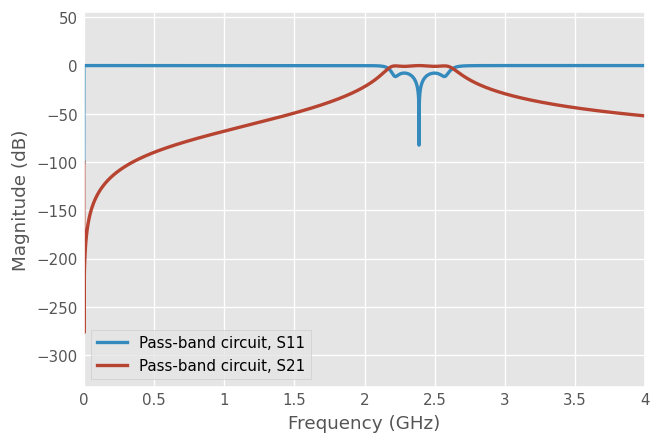

In [18]:

passband_circuit = circuit.network
passband_circuit.name = 'Pass-band circuit'

passband_circuit.plot_s_db(m=0, n=0, lw=2)
passband_circuit.plot_s_db(m=1, n=0, lw=2)

c) Projecte e simule o filtro usando uma implementação em microstrip coupled lines.



d) Faça uma implementação final do filtro e sua optimização usando uma
implementação em hairpin.



e) Faça a simulação electromagnética do layout do filtro e compare os resultados
obtidos.
Nota: Ver livros “Microwave Engineering”, David M. Pozar e “HF Filter Design and
Computer Simulation”, Randall W. Rhea.